In [5]:
import sys
import os
from pathlib import Path

# importディレクトリの追加
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
print(sys.path)

# プロキシの設定
# os.environ['HTTP_PROXY'] = ''
# os.environ['HTTPS_PROXY'] = ''

%matplotlib inline

['/home/y-katayama/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/y-katayama/venv/pt1.7/lib/python3.8/site-packages']


In [6]:
!nvidia-smi

Tue Dec  6 10:41:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 40%   32C    P8    17W / 184W |     47MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:03:00.0 Off |                  N/A |
| 40%   

# Datasetの読み込み

- 以下の例では, TorchVisionからFashion-MNISTをロードする
- Fashion-MNISTは、60,000個の訓練データと10,000個のテストデータから構成された、Zalandoの記事画像のデータセット
- 各サンプルは、28×28のグレースケール画像と、10クラスのうちの1つのラベルから構成される

- FashionMNIST Datasetを読み込む際には、以下のパラメータを使用します。

  - root ：訓練/テストデータが格納されているパスを指定
  - train ：訓練データまたはテストデータセットを指定
  - download=True：root にデータが存在しない場合は、インターネットからデータをダウンロードを指定
  - transform と target_transform：特徴量とラベルの変換を指定

In [68]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor())

100.0%

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


111.0%

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


100.0%

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


159.1%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/home/y-katayama/venv/pt1.7/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# データセットの反復処理と可視化

- Datasetの特定indexを指定する際には、リスト操作と同様に、`training_data[index]`と記載します。

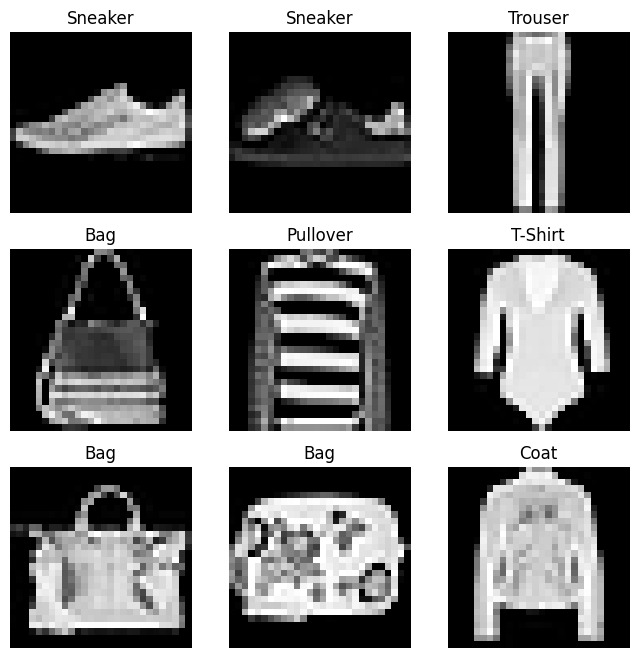

In [69]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",    
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

# カスタムデータセットの作成

- 自分でカスタムしたDatasetクラスを作る際は**以下の関数を必ず実装する必要がある**
  - `__init__`
  - `__len__`
  - `__getitem__`

In [73]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """datasetオブジェクトのインスタンス化される際に一度だけ実行される
        画像, アノテーションファイルと, それらに対する変換処理の初期設定を行う
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transofmr = target_transform
        
    def __len__(self):
        """データセットのサンプル数を返す"""
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        """指定されたidxに対応するサンプル(画像とラベル)をデータセットから読み込んで返す
        """
        
        img_path = os.path.join(self, img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transofm(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        sample = {'image': image, 'label': label}
        return sample

## DataLoaderの使用方法